# Maternal Health Risk Assessment: A Comprehensive Model of Predictive Factors



#### Introduction:


According to the World Health Organization (WHO), maternal health can be defined as “the health of women during pregnancy, childbirth and the postnatal period. Each stage should be a positive experience, ensuring women and their babies reach their full potential for health and well-being” (WHO). The commitment to improving maternal health is not only a priority for organizations like WHO but also a central goal in the post-2015 framework for sustainable development, highlighting its enduring significance in shaping global progress.  This commitment is intricately linked to the broader context of reducing inequality, thereby promoting social justice. By addressing disparities in the quality and outcomes of care from country to country, especially in third world countries that have higher maternal health risks, there is a dedication to ensuring fair and equal opportunities for all women, irrespective of their background or geographical location.

In essence, organizations like WHO who see maternal health as key priority translates into contributing to the effort of reducing maternal health risks by, for example, “increasing research evidence, providing evidence-based clinical and programmatic guidance, setting global standards, and providing technical support to Member States on developing and implementing effective policy and programmes” (WHO). This is why recognizing the gravity of this issue is a palpable urgency to employ innovative approaches for mitigation. A potential avenue of impactful intervention lies in the development of a predictive model. This model holds the potential to discern high-risk patients among pregnant women, thereby empowering healthcare providers to allocate resources to enhance the likelihood of successful outcomes for both mothers and their newborns. 

In this report we will answer the question: Can we determine, with precision, whether a pregnant woman faces low, medium, or high maternal health risk based on key variables such as age, systolic blood pressure, diastolic blood pressure, blood glucose, body temperature, and heart rate? To answer this question, this report uses as its foundation a dataset gathered from 1013 pregnant women. This dataset represents a diverse cross-section, sourced from hospitals, clinics, and maternal health care centers embedded in the rural landscapes of Bangladesh. Each data point encapsulates the variables of interest, forming the basis for our robust predictive model. The dataset contains overall 7 columns for: age, systolic blood pressure, diastolic blood pressure, blood glucose (BS), body temperature, heart rate, and the risk classification. Age is given in years, systolic and diastolic blood pressure in mmHg, blood glucose in mmol/L, body temperature in degrees Fahrenheit, heart rate in bpm, and risk level as a categorical variables for three classifications: low risk, medium risk, and high risk. 


#### Data Selection:
Based on the data analysis, it has become apparent that the temperature variable does not significantly contribute to distinguishing between high, medium and low-risk patients. The temperature remains within the same range for all risk groups. Therefore, it would be misleading to consider temperature as a crucial factor in determining whether a pregnant woman is at high/medium/low risk. 

In alignment with our data analysis, our decision to exclude temperature as a significant variable in determining maternal health risk is supported by a complementary study conducted by Marzia Ahmed and Mohammod Abul Kashem from the Department of Software Engineering at Daffodil International University and the Department of Computer Science and Engineering at Dhaka University of Science and Technology, respectively. Their work utilized a significance ranking system to assess the influence of the factors (age, systolic blood pressure, diastolic blood pressure, blood glucose (BS), body temperature, and heart rate).

According to their findings, blood sugar (BS) emerged as the most influential risk factor in pregnancy, “Especially the mother affected by diabetes is considerably more responsible about three times higher than Blood Pressure and other factors” (Ahmed & Kashem, 2020). Notably, their analysis, rooted in the context of decision trees and entropy, indicated that temperature had a comparatively lower influence over the risk classification. 

In light of this corroborating evidence, our decision to exclude temperature from our risk assessment model aligns with the observed minimal impact of temperature on distinguishing between high, medium, and low-risk patients in our dataset. The temperature variable, remaining within the same range across all risk groups, lacks the discriminatory power demonstrated by other variables, such as blood sugar and blood pressure, as elucidated by Ahmed and Kashem's comprehensive analysis.


#### Preliminary exploratory data analysis:
We are reading the dataset from UCI Machine Learning Repository from the Web to R with the following steps. In summary, we need to download the file, unzip, give it a new name and read the first 6 rows. 

#### Methods:

Based on the data analysis, it has become apparent that the temperature variable does not significantly contribute to distinguishing between high, medium and low-risk patients. The temperature remains within the same range for all risk groups. Therefore, it would be misleading to consider temperature as a crucial factor in determining whether a pregnant woman is at high/medium/low risk.

To visualize the distribution of each quantitative variable and its relationship with the target predictive variable, RiskLevel, we created histograms for each variable. Additionally, we used different colors to represent the 3 levels of the RiskLevel variable. 


#### Step 1: Loading dataset from the web
First, we need to read the data from the dataset into R. Here we use `head()` to show the first 6 lines of the data and give a brief look of the data. We name it as `maternal_original_data`.

In [1]:
## reading the data into R
temp <- tempfile()
download.file("https://archive.ics.uci.edu/static/public/863/maternal+health+risk.zip",temp)
maternal_original_data <- read.csv(unzip(temp, "Maternal Health Risk Data Set.csv"))
unlink(temp)
head(maternal_original_data)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>
1,25,130,80,15.00,98,86,high risk
2,35,140,90,13.00,98,70,high risk
3,29,90,70,8.00,100,80,high risk
4,30,140,85,7.00,98,70,high risk
5,35,120,60,6.10,98,76,low risk
6,23,140,80,7.01,98,70,high risk


Before we tidy up the data, we need to check if there is N/A value in the dataset. If so, it could make our analysis biased or even affect the model performance. Let's check!

In [2]:
# no NA value within the data
has_na <- any(is.na(maternal_original_data))
has_na

[1] FALSE

Perfect! We don't need to worry about N/A value issue. Now we can move on...

### Summary of the original data before wrangling

By looking at `marternal_original_data`, we provide interpretations of each column:
- **Age**: Age in years
- **SystolicBP**: Systolic blood pressure(measures the pressure in arteries when heart beats in mmHg)
- **DiastolicBP**: Diastolic blood pressure(measure the pressure in arteries when heart rests between beats in mmHg)
- **BS**: Blood Glucose Level(in terms of a molar concentration in mmol/L)
- **BodyTemp**: Body temperature measured in Fahrenheit 
- **HearRate**: Heart rate(normal resting heart rate in bpm)
- **RiskLevel**: Predicted risk intensity level of maternal health during pregnancy considering all the prior attributes)

Other information of the original data that we want to mention is:

- There are 1013 subjects within the whole data set.


In [3]:
## loading the packages
library(tidyverse)
library(dplyr)
library(repr)
library(tidymodels)
install.packages("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

#### Step 2: Wrangling and cleaning

Since Celcius is a more common temperature unit to us, we decide to transfer Fahrenheit scale to Celcius scale.

In [4]:
## Adding the Celcius column for interpretation purposes
maternal_with_celcius <- maternal_original_data |> 
                         mutate(Celcius = (BodyTemp - 32) * 5/9 ) 
head(maternal_with_celcius)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,Celcius
,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>,<dbl>
1,25,130,80,15.00,98,86,high risk,36.66667
2,35,140,90,13.00,98,70,high risk,36.66667
3,29,90,70,8.00,100,80,high risk,37.77778
4,30,140,85,7.00,98,70,high risk,36.66667
5,35,120,60,6.10,98,76,low risk,36.66667
6,23,140,80,7.01,98,70,high risk,36.66667


A good dataset should always include readable variable names, so we rename our variables for each column. 

In [5]:
## Rename the columns 
names(maternal_with_celcius) <- c("Age", 
                                  "Systolic_Blood_Pressure", 
                                  "Diastolic_Blood_Pressure", 
                                  "Blood_Glucose", #mmol/L	
                                  "Farenheit",
                                  "Heart_Beat", #bpm
                                  "Risk_Level",
                                  "Body_Temp_Celcius")
maternal_new_name <- maternal_with_celcius
# Removing farenheit
maternal_new_name <- select(maternal_new_name, 
                            Age, 
                            Systolic_Blood_Pressure, 
                            Diastolic_Blood_Pressure,
                            Blood_Glucose,
                            Heart_Beat,
                            Risk_Level,
                            Body_Temp_Celcius)
head(maternal_new_name)

,Age,Systolic_Blood_Pressure,Diastolic_Blood_Pressure,Blood_Glucose,Heart_Beat,Risk_Level,Body_Temp_Celcius
,<int>,<int>,<int>,<dbl>,<int>,<chr>,<dbl>
1,25,130,80,15.00,86,high risk,36.66667
2,35,140,90,13.00,70,high risk,36.66667
3,29,90,70,8.00,80,high risk,37.77778
4,30,140,85,7.00,70,high risk,36.66667
5,35,120,60,6.10,76,low risk,36.66667
6,23,140,80,7.01,70,high risk,36.66667


First, we added the Celsius column to help with understanding of the data later, and we also changed the column names so they are easier to identify. Then we removed the farenheit column because it's unnecessary now there's a Celsius column.

We classify based on risk levels, so `Risk_Level` will be a factor. As we have 6 predictors, we want to choose our predictors for the model wisely and avoid irrelevant variables as much as possible. Hence, using histogram to see the numbers of each predictors among risk levels is helpful.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


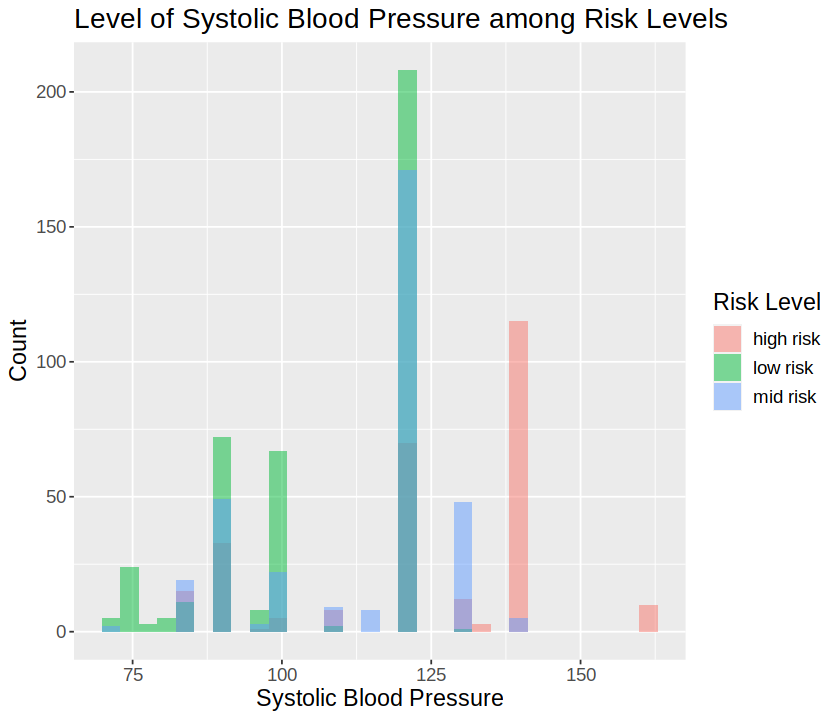

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


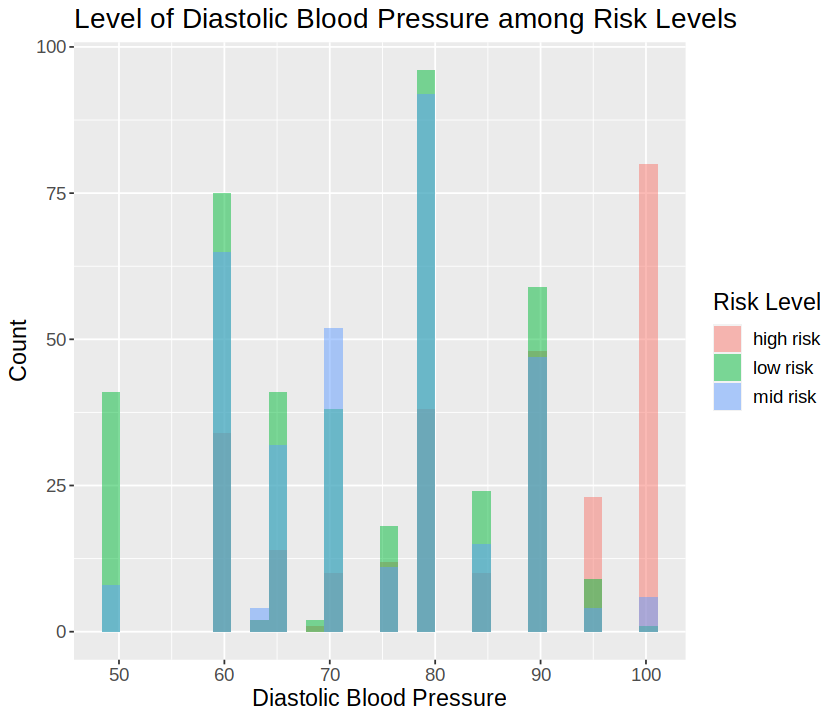

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


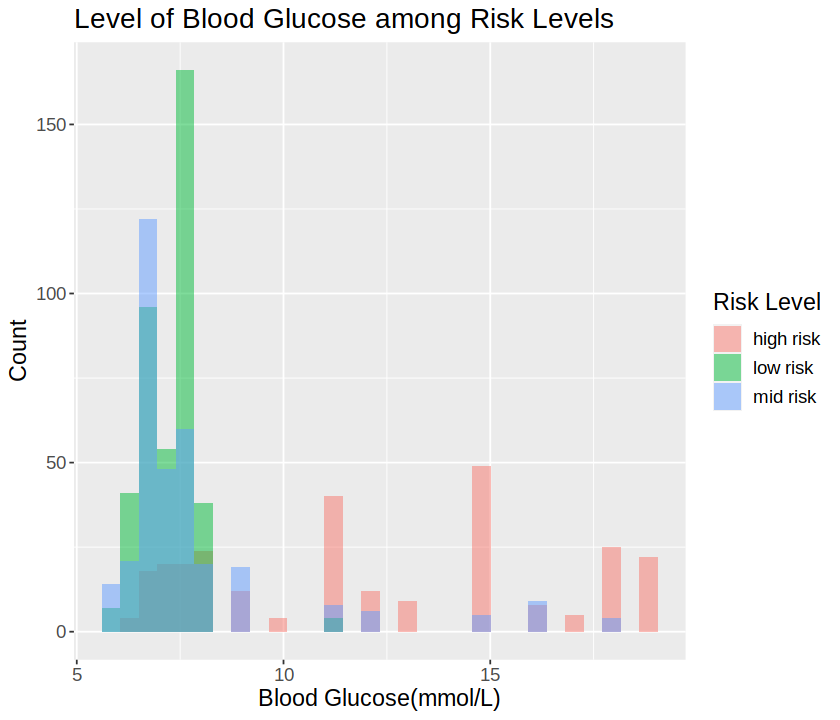

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


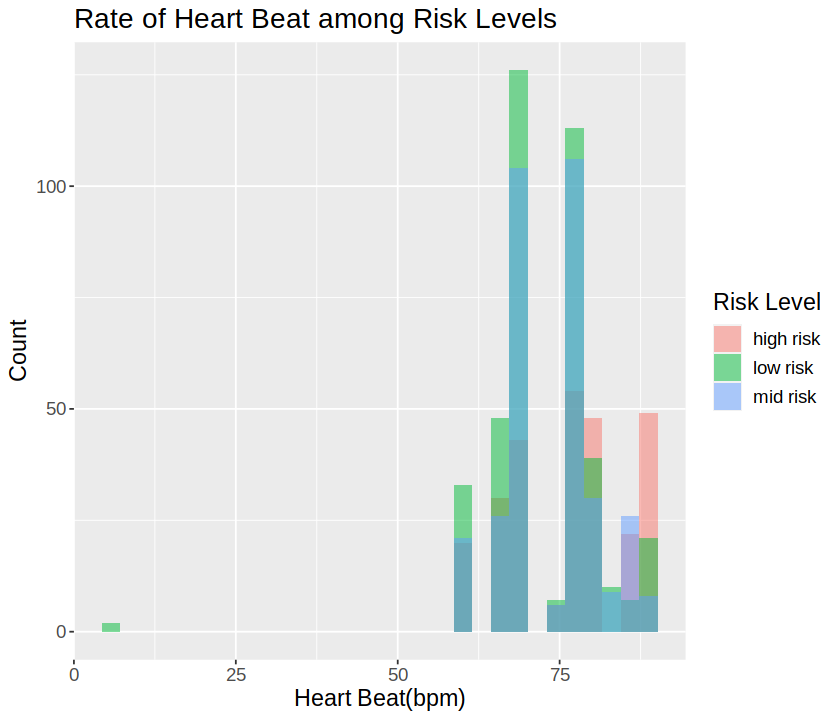

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


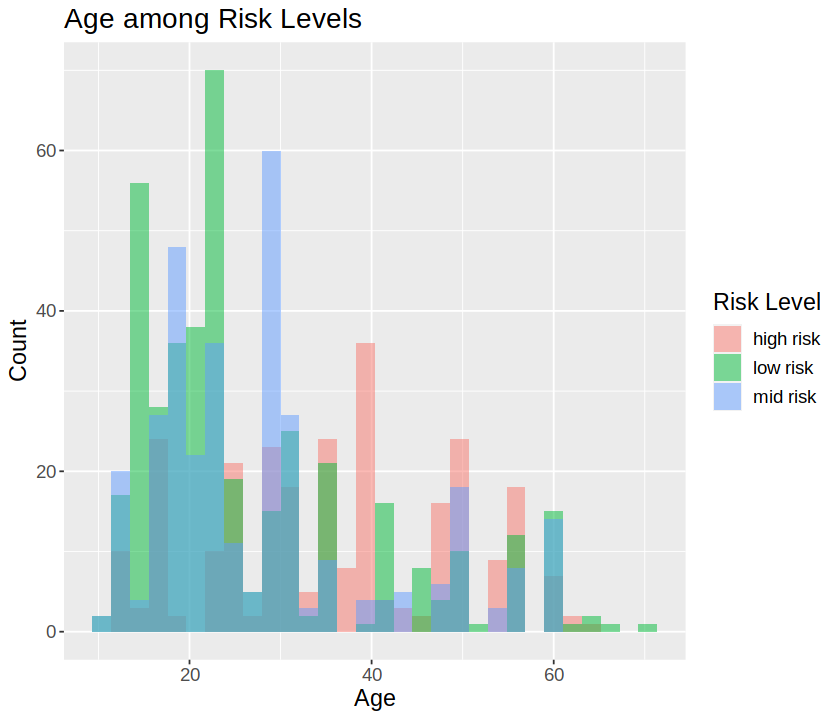

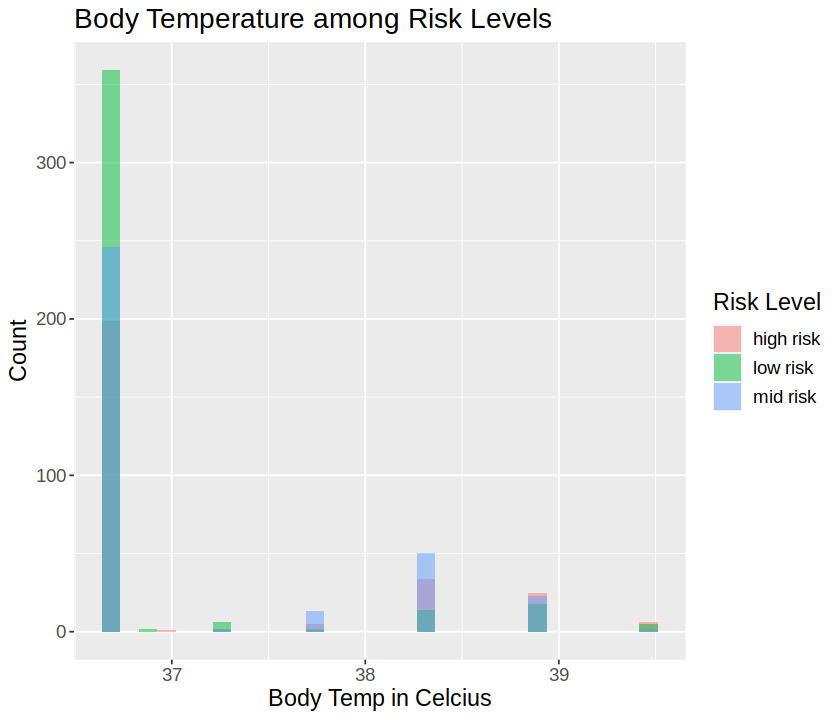

In [6]:
options(repr.plot.width = 7, repr.plot.height = 6) 
# initial visualization
systolic_hisrogram <- ggplot(maternal_new_name, aes(x = Systolic_Blood_Pressure, fill = as_factor(Risk_Level))) +
                     geom_histogram(alpha = 0.5, position = "identity") +
                     labs(x = "Systolic Blood Pressure", fill = "Risk Level", y = "Count") +
                     ggtitle("Level of Systolic Blood Pressure among Risk Levels") +
                     theme(text = element_text(size = 14))
systolic_hisrogram
diastolic_histogram <- ggplot(maternal_new_name, aes(x = Diastolic_Blood_Pressure, fill = as_factor(Risk_Level))) +
                     geom_histogram(alpha = 0.5, position = "identity") +
                     labs(x = "Diastolic Blood Pressure", fill = "Risk Level", y = "Count") +
                     ggtitle("Level of Diastolic Blood Pressure among Risk Levels") +
                     theme(text = element_text(size = 14))
diastolic_histogram
bs_histogram <- ggplot(maternal_new_name, aes(x = Blood_Glucose, fill = as_factor(Risk_Level))) +
                     geom_histogram(alpha = 0.5, position = "identity") +
                     labs(x = "Blood Glucose(mmol/L)", fill = "Risk Level", y = "Count") +
                     ggtitle("Level of Blood Glucose among Risk Levels") +
                     theme(text = element_text(size = 14))
bs_histogram
heart_beat_histogram <- ggplot(maternal_new_name, aes(x = Heart_Beat, fill = as_factor(Risk_Level))) +
                     geom_histogram(alpha = 0.5, position = "identity") +
                     labs(x = "Heart Beat(bpm)", fill = "Risk Level", y = "Count") +
                     ggtitle("Rate of Heart Beat among Risk Levels") +
                     theme(text = element_text(size = 14))
heart_beat_histogram
age_histogram <- ggplot(maternal_new_name, aes(x = Age, fill = as_factor(Risk_Level))) +
                     geom_histogram(alpha = 0.5, position = "identity") +
                     labs(x = "Age", fill = "Risk Level", y = "Count") +
                     ggtitle("Age among Risk Levels") +
                     theme(text = element_text(size = 14))
age_histogram
celsius_histogram <- ggplot(maternal_new_name, aes(x = Body_Temp_Celcius, fill = as_factor(Risk_Level))) +
                     geom_histogram(alpha = 0.5, position = "identity") +
                     labs(x = "Body Temp in Celcius", fill = "Risk Level", y = "Count") +
                     ggtitle("Body Temperature among Risk Levels") +
                     theme(text = element_text(size = 14))
celsius_histogram

From the above visualizations, we can conclude a few things:
1. Temperature is not worth using as a predictor because the distribution of different risk levels remain about the same for those small changes within the temperature. The overall temperature also remained within the normal range around 36 to 39 degrees. It's also extremely right skewed meaning majority of the women had a normal temperature in this data set, therefore, it will be misleading to use temperature as a predictor for the prediction. 
2. Blood glucose, age and systolic and diastolic blood pressure are 4 predictors that visually seem especially important to the prediction because as both four variables increase, high risk level starts to appear more often. 
3. Although heart beat doesn't show as clear of a trend as the other predictors, there still seem to have a connection between heart beat and risk level because the risk level does increase as heart beat increases.
In conclusion, after examining the initial visualizations, we determine to use **age**, **systolic blood pressure**, **diastolic blood pressure**, **blood glucose**, and **heart beat** as predictors.

We ignore `Body_Temp_Celcius` and make `Risk_Level` as factor for classification. The final dataset is named as `maternal_final`.

In [7]:
## Delete body temperature column
maternal_final <- maternal_new_name |>
                  select(Age,Systolic_Blood_Pressure,Diastolic_Blood_Pressure,
                         Blood_Glucose, Heart_Beat, Risk_Level) |>
                  mutate(Risk_Level = as_factor(Risk_Level))
head(maternal_final)

,Age,Systolic_Blood_Pressure,Diastolic_Blood_Pressure,Blood_Glucose,Heart_Beat,Risk_Level
,<int>,<int>,<int>,<dbl>,<int>,<fct>
1,25,130,80,15.00,86,high risk
2,35,140,90,13.00,70,high risk
3,29,90,70,8.00,80,high risk
4,30,140,85,7.00,70,high risk
5,35,120,60,6.10,76,low risk
6,23,140,80,7.01,70,high risk


After cleaning the data by getting rid of unnecessary columns, we will set seeds and split the data to prepare with the classification process.

In [9]:
## Setting seed and splitting data into trianing set and testing set 
set.seed(10)
maternal_split <- initial_split(maternal_final, prop = 0.75, strata = Risk_Level)
maternal_train <- training(maternal_split)
maternal_test <- testing(maternal_split) 
glimpse(maternal_train)
glimpse(maternal_test)

Rows: 760
Columns: 6
$ Age                      <int> 30, 23, 35, 50, 40, 48, 23, 34, 50, 42, 32, 3…
$ Systolic_Blood_Pressure  <int> 140, 140, 85, 140, 140, 140, 140, 85, 140, 14…
$ Diastolic_Blood_Pressure <int> 85, 80, 60, 90, 100, 90, 90, 60, 90, 100, 100…
$ Blood_Glucose            <dbl> 7.00, 7.01, 11.00, 15.00, 18.00, 15.00, 6.80,…
$ Heart_Beat               <int> 70, 70, 86, 90, 90, 90, 70, 86, 90, 90, 78, 8…
$ Risk_Level               <fct> high risk, high risk, high risk, high risk, h…
Rows: 254
Columns: 6
$ Age                      <int> 25, 35, 29, 35, 42, 19, 25, 10, 21, 20, 22, 2…
$ Systolic_Blood_Pressure  <int> 130, 140, 90, 120, 130, 120, 140, 70, 120, 10…
$ Diastolic_Blood_Pressure <int> 80, 90, 70, 60, 80, 80, 100, 50, 80, 90, 90, …
$ Blood_Glucose            <dbl> 15.00, 13.00, 8.00, 6.10, 18.00, 7.00, 7.01, …
$ Heart_Beat               <int> 86, 70, 80, 76, 70, 70, 80, 70, 76, 88, 82, 8…
$ Risk_Level               <fct> high risk, high risk, high risk, low risk, hi

#### Step 4: Finding optimal k

In [10]:
# recipe for training data
maternal_recipe <- recipe(Risk_Level ~.,
                          data = maternal_train) |>
                   step_scale(all_predictors()) |>
                   step_center(all_predictors())
maternal_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [11]:
# model for training data 
maternal_spec <- nearest_neighbor(weight_fun = "rectangular", neighbors = tune()) |>
                 set_engine("kknn") |>
                 set_mode("classification")
maternal_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [12]:
# creating v folds for traning data 
maternal_vfold_10 <- vfold_cv(maternal_train, v = 10, strata = Risk_Level)

# data frame that contains sequence of K values
maternal_k_vals <- tibble(neighbors = seq(from = 1, to = 70, by = 1))

We starts finding the optimal K by creating a recipe with all the necessary predictors, a model for classification. Next, we decides to first try 10 folds because we have a relatively big size of data, and we kept the range of k values around 1/3 of the amount within training set. 

In [13]:
# fitting the model
maternal_first_workflow <- workflow () |>
                           add_recipe(maternal_recipe) |>
                           add_model(maternal_spec) |>
                           tune_grid(resamples = maternal_vfold_10, grid = maternal_k_vals) |>
                           collect_metrics()
                        
head(maternal_first_workflow)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8078595,10,0.01843905,Preprocessor1_Model01
1,roc_auc,hand_till,0.8583550,10,0.01298562,Preprocessor1_Model01
2,accuracy,multiclass,0.7985594,10,0.02015608,Preprocessor1_Model02
2,roc_auc,hand_till,0.8586280,10,0.01336624,Preprocessor1_Model02
3,accuracy,multiclass,0.6959341,10,0.01871669,Preprocessor1_Model03
3,roc_auc,hand_till,0.8497369,10,0.01431789,Preprocessor1_Model03


In [ ]:
# getting only the accuracies
accuracies <- maternal_first_workflow |>
             filter(.metric == "accuracy")

# accuracy plot
accuracy_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_plot

From this plot, it's clear that the amount of neighbor we need will be very relatively small, therefore we made a second plot with less neighbors to get a better read of the amount of k we need.

In [ ]:
# new k values
maternal_k <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# fitting the newer model
maternal_new_workflow <- workflow () |>
                           add_recipe(maternal_recipe) |>
                           add_model(maternal_spec) |>
                           tune_grid(resamples = maternal_vfold_10, grid = maternal_k) |>
                           collect_metrics()
head(maternal_new_workflow)

# getting only the accuracies
accuracy <- maternal_new_workflow |>
             filter(.metric == "accuracy")

# accuracy plot
accuracy_plot_2 <- ggplot(accuracy, aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "Neighbors", y = "Accuracy Estimate") +
                scale_x_continuous(breaks = seq(0, 14, by = 1)) +
                scale_y_continuous(limits = c(0.4, 1.0))
accuracy_plot_2

After tuning the grid, filtering out the accuracy and plotting out the elbow plot. We've determined that k = # would provide the highest accuracy.

#### Step 5: Final model

In [ ]:
# new model
maternal_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
                       set_engine("kknn") |>
                       set_mode("classification")

# new workflow
maternal_final_workflow <- workflow() |>
                           add_recipe(maternal_recipe) |>
                           add_model(maternal_final_spec) |>
                           fit(data = maternal_train)
maternal_final_workflow

With our new k value, we created a new model and fit it again for the final workflow to use in predictions of the test data set.

In [ ]:
# predicting testing data
maternal_predict <- predict(maternal_final_workflow, maternal_test) |>
                    bind_cols(maternal_test)
head(maternal_predict)

In [ ]:
# assessing classifier's performance
maternal_metrics <- maternal_predict |>
                    metrics(truth = Risk_Level, estimate = .pred_class) |>
                    filter(.metric == "accuracy")
maternal_metrics

In [ ]:
# producing the confusion matrix
maternal_matrix <- maternal_predict |>
                   conf_mat(truth = Risk_Level, estimate = .pred_class)
maternal_matrix

CONFUSION MATRIX ANALYSIS IMPORTANT!!!

In [ ]:
maternal_final

In [ ]:
plot_age_vs_blood_glucose <- ggplot(maternal_final, aes(x = Age, y = Blood_Glocose, color = Risk_Level)) +
                            geom_point(alpha = 0.5) +
                            labs(color = "Risk Level") +
                            ggtitle("Scatter plot of Age versus Blood Glocose colored by risk level") +
                            theme(text = element_text(size = 12))

#### Expected outcomes and significance:

- Expected Findings:
  
Multifactorial Nature of Risk: The multifactorial nature of maternal health risks suggests that multiple variables collectively contribute to the overall risk assessment, highlighting that no single factor holds all the weight in determining risk.
Identifying correlations and associations: Variables like blood pressure, body temperature, and blood sugar levels positively impact risk assessment, with older mothers having higher maternity risk.

- Impact of Findings:

The analysis of variables and expected risk in the maternal health dataset can significantly influence maternal healthcare, healthcare policy, and public health initiatives.
1) Preventive Health Education: Understanding risk factors can aid in creating health education programs promoting healthy lifestyle choices, including prenatal care, diet-related risk reduction, and general health practices among pregnant women.
2) Evidence-Based Policy Formulation: The findings could guide the development of evidence-based policies in maternal healthcare, aiming to reduce maternal health risk factors.
3) Research and Innovation: The findings could drive further research and innovation in maternal health, focusing on developing novel diagnostic tools, therapeutic interventions, and preventive measures to address identified risk factors, thereby improving treatment options and health outcomes for pregnant women.

- Future Questions:
  
1) Personalized Care Plans: How can the insights from the predictive model be used to create personalized care plans for pregnant women, considering their individual health profiles? 
2) Monitoring and Evaluation: How can the model be integrated into the monitoring and evaluation system to identify high-risk expecting mothers and ensure frequent monitoring to enhance maternal health outcomes?

#### References Used:

Ahmed,Marzia. (2023). Maternal Health Risk. UCI Machine Learning Repository. https://doi.org/10.24432/C5DP5D.